In [1]:
import pandas as pd
import re 
import numpy as np
import networkx as nx

In [2]:
#relevant paths 
allDataPath = "/shared/3/projects/benlitterer/podcastData/processed/mayJune/mayJuneDataRoles.feather"

transcriptTopicsPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/40/transcripts/doc_topics.txt"
descTopicsPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/40/descriptions/doc_topics.txt"

transcriptKeysPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/40/transcripts/topic_keys.txt"
descKeysPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/40/descriptions/topic_keys.txt"

rjTopicsPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/200/transcripts/doc_topics.txt"
rjTopics = pd.read_csv(rjTopicsPath, sep="\t", header=None, index_col=0)

In [3]:
#first just focus on merging topics onto dataframe 
#so read in podcast data 
#df = pd.read_json(allDataPath, orient="records", lines=True)
df = pd.read_feather(allDataPath)

In [67]:
print(f"predicted guests: {sum(df['uniqueGuests'].fillna(0))}")
print(f"predicted hosts: {sum(df['uniqueHosts'].fillna(0))}") 
print(f"predicted neithers: {sum(df['uniqueNeithers'].fillna(0))}")

predicted guests: 385932.0
predicted hosts: 535355.0
predicted neithers: 724631.0


In [60]:
df["uniqueGuests"].head() 

0    NaN
1    NaN
2    NaN
3    NaN
4    1.0
Name: uniqueGuests, dtype: float64

In [5]:
N_TOPICS=40

transcriptTopics = pd.read_csv(transcriptTopicsPath, sep="\t", header=None, index_col=0)
transcriptTopics.columns = ["potentialOutPath"] + ["transcript" + str(item) for item in list(range(0, N_TOPICS))]

descTopics = pd.read_csv(descTopicsPath, sep="\t", header=None, index_col=0)
descTopics.columns = ["potentialOutPath"] + ["desc" + str(item) for item in list(range(0, N_TOPICS))]

In [6]:
df = pd.merge(df,transcriptTopics, on="potentialOutPath", how="left")
df = pd.merge(df, descTopics, on="potentialOutPath", how="left")

In [7]:
print(df.shape)
print(df.columns)

(1124058, 182)
Index(['fullPotentialOutPath', 'transcript', 'potentialOutPath', 'rssUrl',
       'epTitle', 'epDescription', 'duration', 'pubDate', 'itunes:type',
       'itunes:complete',
       ...
       'desc30', 'desc31', 'desc32', 'desc33', 'desc34', 'desc35', 'desc36',
       'desc37', 'desc38', 'desc39'],
      dtype='object', length=182)


In [8]:
#group at the guest-level 
commonGuests = df[["rssUrl", "guestPredictedNames", "title", "podDescription", "epDescription", "category1"]].explode("guestPredictedNames")
commonGuests = commonGuests.groupby("guestPredictedNames").agg(set)
newFeatures = {k:k + "Guest" for k in commonGuests.columns}
commonGuests = commonGuests.reset_index().rename(columns=newFeatures)

commonGuests["appearences"] = commonGuests["titleGuest"].apply(len)
#commonGuests[commonGuests["appearences"] > 1]

commonGuests = commonGuests.rename(columns={"guestPredictedNames":"guestName"})

In [16]:
print(f"total guests: {len(commonGuests)}") 

total guests: 281158


In [17]:
#get total guest mentions
#was using this to try and pick up on name frequency 
'''
guestMentions = df[["neitherPredictedNames", "rssUrl", "title", "epTitle"]].explode("neitherPredictedNames").groupby("neitherPredictedNames").agg(set)
guestMentions["mentions"] = guestMentions["rssUrl"].apply(len)
guestMentions = guestMentions.reset_index()
guestMentions = guestMentions.rename(columns={"neitherPredictedNames":"guestName", "rssUrl":"RSSneither", "title":"titleNeither", "guest":"guestNeither"})
commonGuests = pd.merge(commonGuests, guestMentions, on="guestName", how="left")
'''
#only keep rows with no special characters 
commonGuests = commonGuests[commonGuests["guestName"].apply(lambda x: (re.search("[^a-zA-Z ]", x) == None) == True)]

In [18]:
print(f"total guests: {len(commonGuests)}") 

total guests: 268973


In [23]:
longDf = df[["guestPredictedNames", "title", "epTitle", "transcript", "category1"]].explode("guestPredictedNames") #.dropna(subset=["guestPredictedNames"]).set_index("guestPredictedNames")
probDf = longDf[["guestPredictedNames"]].rename(columns={"guestPredictedNames":"guestName"})

#FIRST: just filter out any guests with only 1 appearance 
probDf = probDf.dropna(subset=["guestName"])
probDf = probDf[probDf["guestName"] != None]
probDf[["first", "last"]] = probDf["guestName"].apply(lambda x: x.split(" ")).values.tolist()

#get first prob 
firstProbs = pd.DataFrame(probDf["first"].value_counts()) 
firstProbs = firstProbs / len(probDf)

#get last prob 
lastProbs = pd.DataFrame(probDf["last"].value_counts()) 
lastProbs = lastProbs / len(probDf)

len(firstProbs) * len(lastProbs)

#this is the number of guests 
print(f"prob. df len: {len(probDf)}") 

#estimate the joint probability as a draw from the first and last 
def getJointProb(inName): 
    fProb = firstProbs.loc[inName.split(" ")[0]]
    lProb = lastProbs.loc[inName.split(" ")[1]]
    return fProb * lProb

guestPairs = commonGuests.loc[(commonGuests["appearences"] >= 2)]
guestPairs["jointProb"] = guestPairs["guestName"].apply(getJointProb) 

#just fun to look at 
guestPairs.sort_values("jointProb").head()

probDf = probDf.drop_duplicates()
probDf["jointProb"] = probDf["guestName"].apply(getJointProb)

print(f"number of guests with at least two appearences {len(guestPairs)}")
#get quantiles for guest appearences 
quants = np.quantile(guestPairs["jointProb"], [.25, .5, .75])

prob. df len: 385932


/tmp/ipykernel_2686696/173295249.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guestPairs["jointProb"] = guestPairs["guestName"].apply(getJointProb)


number of guests with at least two appearences 32226


In [24]:
print(f"number of guests with at least two appearences {len(guestPairs)}")

number of guests with at least two appearences 32226


In [21]:

#keep only uncommon names (under median)
guestPairs = guestPairs[(guestPairs["jointProb"] <= quants[1])]
print(f"number of guests with two appearences and under median freq: {len(guestPairs)}")

#manualRemoval = ["George Floyd", "Breonna Taylor", "Breonna Tayler",  "Tony McDade", "Amard Aubrey", "Amad Aubrey", "Jesus Christ"]
#guestPairs = guestPairs[guestPairs["guestName"].isin(manualRemoval) == False]

print(len(guestPairs))

#explode this out into a network 
def getUniquePairs(inList): 
    inList = list(inList)
    outList = []
    for i in range(len(inList)): 
        for j in range(i+1, len(inList)):
            outList.append([inList[i], inList[j]])
    return outList

guestPairs["urlPairs"] = guestPairs["titleGuest"].apply(getUniquePairs)
guestPairs = guestPairs.explode("urlPairs")

print(len(guestPairs))

guestPairs[["source", "target"]] = guestPairs["urlPairs"].to_list()
guestPairs = guestPairs[(guestPairs["source"] != None) & (guestPairs["target"] != None)]
guestPairs = guestPairs.dropna(subset=["source", "target", "guestName"])
#guestPairs = guestPairs.reset_index()
guestGraph = nx.from_pandas_edgelist(guestPairs, source="source", target="target", edge_attr="guestName")


number of guests with at least two appearences 16113
16113
42936


In [59]:
#punch in here to grab an example name!
probDf.sort_values("jointProb").tail(20)

,guestName,first,last,jointProb
8113,Mike Johnson,Mike,Johnson,0.000061
87986,Brian Smith,Brian,Smith,0.000062
22540,David Williams,David,Williams,0.000062
68539,Chris Williams,Chris,Williams,0.000062
16818,Michael Johnson,Michael,Johnson,0.000064
234690,David Brown,David,Brown,0.000069
39953,Chris Brown,Chris,Brown,0.000069
66775,Matt Smith,Matt,Smith,0.000074
163875,David Johnson,David,Johnson,0.000074
150895,Chris Johnson,Chris,Johnson,0.000074


In [25]:
#now get the topic information figured out 
#first, what are the big topics? 
transcriptKeys = pd.read_csv(transcriptKeysPath, sep="\t", names=["topicNum", "proportion", "topWords"]).sort_values("proportion", ascending=False)
descKeys = pd.read_csv(descKeysPath, sep="\t", names=["topicNum", "proportion", "topWords"]).sort_values("proportion", ascending=False)

In [12]:
#topics to drop: 
#toDrop = [45, 35, 58, 37, 9, 31, 36, 26, 22, 65, 3, 69, 14, 71, 52, 56, 77, 1, 15, 97, 5]
#kept: 27, 51
#topicKeys.iloc[90:100, :]

In [26]:
#just start by getting the top columns
transCols = ["transcript" + str(item) for item in range(0, N_TOPICS)]
descCols = ["desc" + str(item) for item in range(0, N_TOPICS)]

#don't drop any columns for now
toDrop = []

def assignCat(inRow, inCols): 
    topCat = inCols[np.argmax(inRow)]
    return topCat

#cols = df.loc[:,0:99].drop(columns=toDrop).columns
#df["topTopic"] = df.loc[:,0:99].drop(columns=toDrop).apply(assignCat, axis=1)

df["topTransTopic"] = df.loc[:,transCols].drop(columns=toDrop).apply(assignCat, args=[transCols], axis=1)
df["topDescTopic"] = df.loc[:,descCols].drop(columns=toDrop).apply(assignCat, args=[descCols], axis=1)

/opt/anaconda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  return bound(*args, **kwds)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
outDict = {}
cats=["business", "sports", "news", "religion"]
for category in cats: 
    currDf = pd.DataFrame(df.loc[df["category1"] == category, "topTransTopic"].value_counts()).reset_index().sort_values("topTransTopic")
    #toAvoid = list(currDf.sort_values("count").head(20)["topTransTopic"])
    #currDf = currDf[currDf["topTransTopic"].isin(toAvoid) == False]
    currDf["fracs"] = currDf["count"] / sum(currDf["count"]) 
    print(category)
    print(currDf.head())
    outDict[category] = list(currDf["fracs"])
heatDf = pd.DataFrame(outDict)
heatDf = heatDf.set_index(currDf["topTransTopic"].apply(lambda x: x.replace("transcript", "Topic_")))

business
   topTransTopic  count     fracs
18   transcript0   1070  0.008067
3    transcript1  10892  0.082117
16  transcript10   1194  0.009002
30  transcript11    320  0.002413
33  transcript12    240  0.001809
sports
   topTransTopic  count     fracs
15   transcript0    741  0.007829
24   transcript1    191  0.002018
23  transcript10    238  0.002515
25  transcript11    163  0.001722
38  transcript12     18  0.000190
news
   topTransTopic  count     fracs
18   transcript0   1470  0.018231
17   transcript1   1571  0.019483
0   transcript10  11640  0.144358
28  transcript11    531  0.006585
37  transcript12    179  0.002220
religion
   topTransTopic  count     fracs
25   transcript0    487  0.002557
27   transcript1    397  0.002084
22  transcript10   1036  0.005440
24  transcript11    528  0.002772
1   transcript12  45524  0.239026


In [29]:
#remove topics that aren't that popular overall 
heatDf.head() 
heatDf["mean"] = heatDf.apply(np.mean, axis=1)
heatDf = heatDf.sort_values("mean", ascending=False).drop(columns="mean")

In [30]:
heatDf.head() 

,business,sports,news,religion
topTransTopic,,,,
Topic_39,0.004493,0.000190,0.002952,0.288628
Topic_18,0.255979,0.003402,0.020091,0.002016
Topic_12,0.001809,0.000190,0.002220,0.239026
Topic_20,0.074517,0.042887,0.059393,0.059620
Topic_33,0.001350,0.203687,0.026937,0.000767


Text(0.5, 0.98, 'Topic Proportions within Different Categories')

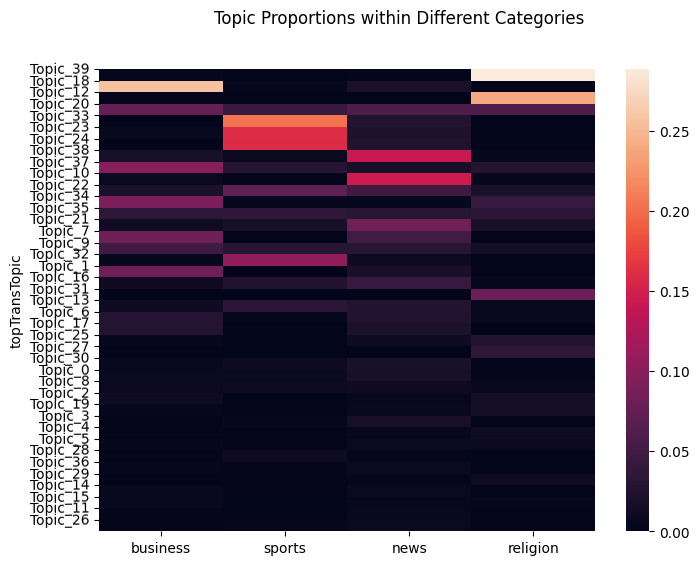

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(heatDf.head(40), vmin=0, ax =ax)
ax.set_yticks(np.arange(0, 40, 1), labels=heatDf.index, rotation=.5)
fig.suptitle("Topic Proportions within Different Categories")

In [32]:
transcriptKeys.loc[transcriptKeys["topicNum"] == 37, "topWords"].item()

"i'm kind years started time people lot i've yeah didn't that's it's back bit wanted things life podcast school work "

In [33]:
'''
with 100 topics 
#what if we just pull out all of the business, news, etc... topics? 
bizTopics = [82, 0, 62, 79, 49, 24, 6, 28, 31, 95, 97]
sportsTopics = [21, 72, 57, 93, 41, 30, 35]
newsTopics = [59, 20, 85, 51, 24, 14, 37, 89]
'''

#with 40 topics 
bizTopics = [18, 37, 34, 1, 7]
sportsTopics = [33, 23, 24]
newsTopics = [10, 38, 21, 32]

toHighlight = bizTopics + sportsTopics + newsTopics

#NOTE: used this manually to pull out topics 
df[df["category1"] == "business"].value_counts("topTransTopic").head(15)

topTransTopic
transcript18    33953
transcript37    12991
transcript34    11899
transcript1     10892
transcript7     10702
transcript20     9884
transcript9      6410
transcript35     4513
transcript6      3873
transcript17     3696
transcript22     2733
transcript38     2458
transcript16     1535
transcript2      1452
transcript21     1424
Name: count, dtype: int64

In [34]:
#TODO: also get topics that aren't really "about anything"
toDrop = []

In [35]:
#but what we actually care about is at the title level!
titleTopics = df.loc[:, ["title"] + transCols + descCols].groupby("title").agg(np.mean).reset_index()

/tmp/ipykernel_2686696/2657979319.py:2: FutureWarning: The provided callable <function mean at 0x7f4954171580> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  titleTopics = df.loc[:, ["title"] + transCols + descCols].groupby("title").agg(np.mean).reset_index()


In [36]:
#make none if it's not in business, for now 
def subsetTopics(inStr, topicList):

    #need to add string to beginning so inStr matches something in the list 
    topicList = ["transcript" + str(item) for item in topicList]
    if inStr in topicList: 
        return inStr
    
    return "None"

In [37]:
#PUNCH IN HERE
df.head()

,fullPotentialOutPath,transcript,potentialOutPath,rssUrl,epTitle,epDescription,duration,pubDate,itunes:type,itunes:complete,...,desc32,desc33,desc34,desc35,desc36,desc37,desc38,desc39,topTransTopic,topDescTopic
0,/shared/3/projects/benlitterer/podcastData/pro...,I'm Simon Shapiro and this is Sing Out Speak ...,/www.buzzsprout.com/o3/httpswww.buzzsprout.com...,https://feeds.buzzsprout.com/783020.rss,Best of SingOut SpeakOut No.3,<p>Best of with snippets from 3 episodes and a...,803,"Sun, 21 Jun 2020 07:00:00 +1000",None,NaN,...,0.001042,0.000739,0.000275,0.000295,0.000369,0.000313,0.000696,0.00044,transcript34,desc12
1,/shared/3/projects/benlitterer/podcastData/pro...,I'm Simon Shapiro and this is Sing Out Speak ...,/www.buzzsprout.com/83/httpswww.buzzsprout.com...,https://feeds.buzzsprout.com/783020.rss,It's All Gone,<p>Simon introduces &apos;It&apos;s all Gone&a...,360,"Sun, 14 Jun 2020 22:00:00 +1000",None,NaN,...,0.001042,0.000739,0.000275,0.000295,0.000369,0.000313,0.000696,0.00044,transcript20,desc12
2,/shared/3/projects/benlitterer/podcastData/pro...,I'm Simon Shapiro and this is Sing Out Speak ...,/www.buzzsprout.com/3y/httpswww.buzzsprout.com...,https://feeds.buzzsprout.com/783020.rss,Today Is Yesterday,"<p>Simon introduces track 4, of the newly rele...",416,"Sun, 31 May 2020 21:00:00 +1000",None,NaN,...,0.001042,0.000739,0.000275,0.000295,0.000369,0.000313,0.000696,0.00044,transcript35,desc12
3,/shared/3/projects/benlitterer/podcastData/pro...,I'm Simon Shapiro and this is Sing Out Speak ...,/www.buzzsprout.com/3r/httpswww.buzzsprout.com...,https://feeds.buzzsprout.com/783020.rss,Saturn Return,"<p>This week, Simon introduces track 2- Saturn...",476,"Sun, 24 May 2020 19:00:00 +1000",None,NaN,...,0.001042,0.000739,0.000275,0.000295,0.000369,0.000313,0.000696,0.00044,transcript9,desc12
4,/shared/3/projects/benlitterer/podcastData/pro...,I'm Simon Shapiro and this is Sing Out Speak ...,/www.buzzsprout.com/30/httpswww.buzzsprout.com...,https://feeds.buzzsprout.com/783020.rss,Quarterlife Crisis,<p>Big news week. The band Simon lived in the ...,509,"Sun, 17 May 2020 20:00:00 +1000",None,NaN,...,0.001042,0.000739,0.000275,0.000295,0.000369,0.000313,0.000696,0.00044,transcript11,desc12


In [38]:
#get the top title topic from the list we care about 
#TODO: maybe try this approach later
#transCols = ["transcript" + str(item) for item in toHighlight]
transCols = ["transcript" + str(item) for item in range(0, N_TOPICS)]

#REMEMBER: we are only looking among the topics we're interested in here 
titleTopics["transTitleTopic"] = titleTopics.loc[:,transCols].apply(assignCat, args=[transCols], axis=1)

#get columns for only certain topic groupings 
titleTopics["transTitleBusiness"] = titleTopics["transTitleTopic"].apply(subsetTopics, args=[bizTopics])
titleTopics["transTitleSports"] = titleTopics["transTitleTopic"].apply(subsetTopics, args=[sportsTopics])
titleTopics["transTitleNews"] = titleTopics["transTitleTopic"].apply(subsetTopics, args=[newsTopics])

df = pd.merge(df, titleTopics[["title", "transTitleTopic", "transTitleBusiness", "transTitleSports", "transTitleNews"]], on="title", how="left")

In [39]:
topicWords = pd.read_csv("/shared/3/projects/benlitterer/podcastData/topicModelling/100/transcripts/topic_keys.txt", sep="\t", names=["topicNum", "prop", "words"])
bizTopics100 = [0, 49, 82, 62]
topicWords[topicWords["topicNum"].isin(bizTopics100)]

,topicNum,prop,words
0,0,0.04205,business people you're businesses clients comp...
49,49,0.01523,real estate property home market house you're ...
62,62,0.02912,marketing sales product brand business product...
82,82,0.04043,company business companies industry technology...


In [40]:
#what if we get difference from mean topic representation? 
#topicProps = topicKeys[topicKeys["topicNum"].isin(toDrop) == False]
#topicProps = topicProps.sort_values("topicNum")["proportion"]
#df["topTopicRelative"] = df.drop(columns=toDrop).loc[:,0:99].apply(lambda row: row - topicProps, axis=1) #.apply(np.argmax, axis=1)

In [41]:
#get the top RJ topic 
rjTopicsPath = "/shared/3/projects/benlitterer/podcastData/topicModelling/200/transcripts/doc_topics.txt"
rjTopics = pd.read_csv(rjTopicsPath, sep="\t", header=None, index_col=0)

In [42]:
rjTopics.columns = ["potentialOutPath"] + list(range(0, 200))

In [43]:
df["cleanDatesLoc"] = pd.to_datetime(df["cleanDatesLoc"], unit="ms") 

In [44]:
#we want to merge in title, merge by title, and find the highest RJ topic for each title 
rjGrouped = pd.merge(df[["title", "potentialOutPath", "cleanDatesLoc"]], rjTopics, on="potentialOutPath", how="inner") 

#consider only episodes after george floyd's murder 
rjGrouped = rjGrouped[rjGrouped["cleanDatesLoc"] > "2020-05-25"]

#take the max, because we want the episode where racial justice is discussed the most 
#we only care about a subset of columns! 
RJCols = [5, 13, 57, 69, 159, 164]
rjGrouped = rjGrouped[["title"] + RJCols] 
rjGrouped = rjGrouped.groupby("title").agg(max)

#get the most represented category! 
#and the max val for that category 
rjGrouped["topTopicVal"] = rjGrouped.apply(max, axis=1)
rjGrouped["topTransTopic"] = rjGrouped.apply(assignCat, args=[RJCols], axis=1)

RJ_CUTOFF = .05
rjGrouped = rjGrouped[rjGrouped["topTopicVal"] > RJ_CUTOFF]

/tmp/ipykernel_2686696/1141725532.py:11: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rjGrouped = rjGrouped.groupby("title").agg(max)


In [45]:
mentionsList = {}
terms = ["george floyd", "race", "black", "protest"]
colNameList = ["gfMentions", "raceMentions", "blackMentions", "protestMentions"]

for i, term in enumerate(terms): 
    print(f"searching {term}")
    currMentions = df[["transcript", "title", "potentialOutPath"]]
    currMentions = currMentions["transcript"].apply(lambda x: re.search(term, x.lower()) != None)
    print(f"searched {term}")

    mentionsList[colNameList[i]] = list(currMentions)

searching george floyd
searched george floyd
searching race
searched race
searching black
searched black
searching protest
searched protest


In [46]:
mentionsDf = pd.DataFrame(mentionsList)
mentionsDf["title"] = df["title"]
mentionsDf = mentionsDf.groupby("title").agg("max")

In [47]:
#dataframes to quickly get metadata for a particular 
#topicRefDf = df[["topTopic", "title"]].set_index("topTopic")

refDf = df[["category1", "title", "transTitleTopic", "transTitleBusiness", "transTitleSports", "transTitleNews" ]].drop_duplicates("title").set_index("title").fillna("None")

#add node attribute of category 
#get dictionary of rss feeds and categories 
#catRef = df[["rssUrl", "category1", "title"]].drop_duplicates().set_index("rssUrl")
for node in guestGraph.nodes(): 
    nodeCat = refDf.loc[node, "category1"]
    nodeTopic = refDf.loc[node, "transTitleTopic"]

    for catName in refDf.columns: 
        nodeVal = refDf.loc[node, catName]
        if nodeVal != None: 
            guestGraph.nodes[node][catName] = nodeVal
        else: 
            guestGraph.nodes[node][catName] = "None" 

    #now do the same thing for the racial justice attributes 
    if node in rjGrouped.index: 
        guestGraph.nodes[node]["hasRJTopic"] = "TRUE"
        guestGraph.nodes[node]["maxRJTopic"] = rjGrouped.loc[node, "topTransTopic"]
    else: 
        guestGraph.nodes[node]["hasRJTopic"] = "FALSE"
        guestGraph.nodes[node]["maxRJTopic"] = "None" 

    for col in colNameList: 
        nodeVal = mentionsDf.loc[node, col]
        guestGraph.nodes[node][col] = str(nodeVal)


In [48]:
nx.write_gexf(guestGraph, f"/shared/3/projects/benlitterer/podcastData/network/BottomNames_{N_TOPICS}Topics_graph.gexf")

In [49]:
nodeDict = guestGraph.nodes.items()

In [50]:
#output edgelist
intGraph = nx.convert_node_labels_to_integers(guestGraph)
components = [c for c in sorted(nx.connected_components(intGraph), key=len, reverse=True)]
componentLens = [len(c) for c in components]
compGraph = intGraph.subgraph(components[0])

nx.write_edgelist(compGraph, "/shared/3/projects/benlitterer/podcastData/network/BottomNames_edgeList.txt", data=False) 

#get mapping from string node-labels to integers 
#nodes = list(guestGraph.nodes())
#nodeDict = dict(zip(nodes, np.arange(0, len(nodes), 1)))


#write metadata to file so we can grab it when making the figure!
#add index in intGraph as a columns 
nodeCount = len(list(guestGraph.nodes()))
nodeDf = pd.DataFrame.from_dict(dict(intGraph.nodes(data=True)), orient='index')
nodeDf["nodeInt"] = list(range(nodeCount))

In [51]:
nodePath="/shared/3/projects/benlitterer/podcastData/network/nodeMetadata40Topics.csv"
nodeDf.to_csv(nodePath, index=False)

In [52]:
edgeListDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/network/BottomNames_edgeList.txt", sep=" ")

In [53]:
len(set(list(edgeListDf["0"]) + list(edgeListDf["1"])))

10649

In [54]:
len(edgeListDf)

28981